Dataset from here: https://edgar.jrc.ec.europa.eu/gallery?release=v2024ghg&substance=CO2&sector=TOTALS

In [1]:
import pandas as pd

In [2]:
co2 = pd.read_csv("./EDGAR_2024_GHG_CO2_2023_TOTALS/EDGAR_2024_GHG_CO2_2023_TOTALS.txt", delimiter=";", skiprows=2)

In [3]:
co2

,lat,lon,emission
0,55.3,72.5,2789.260000
1,28.7,9.3,6963.290000
2,50.7,-113.5,11462.100000
3,53.1,36.1,2175.370000
4,60.6,41.5,1305.630000
...,...,...,...
4196020,9.4,-64.2,0.748653
4196021,-20.9,129.9,96.777000
4196022,-37.9,59.3,1.153120
4196023,-44.7,57.6,2.323890


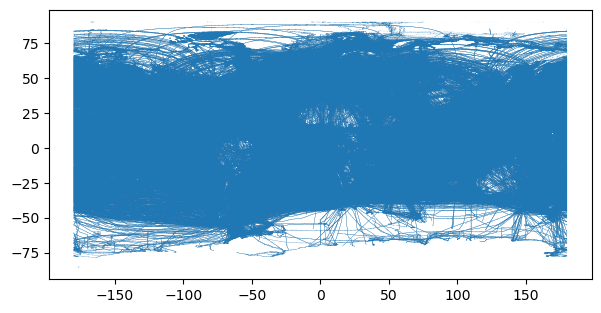

In [4]:
# Basic scatterplot
import matplotlib.pyplot as plt
fig = plt.figure()
fig.set_size_inches(7,3.5)
plt.scatter(co2['lon'], co2['lat'], s=0.05, edgecolors="none")

plt.show()

This data contains very large and very small values, so a linear scale may obscure insights into distribution. Using a logarithmic scale is a better choice. Enhance the visibility of small values, prevents high-value points from dominating.

Using matplotlib.colors.LogNorm() allows us to assign colors to the data based on a log scale.

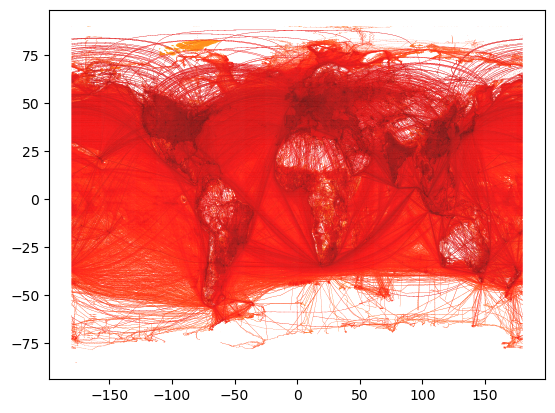

In [5]:
from matplotlib import colors

fig=plt.figure()
plt.scatter(co2['lon'], co2['lat'], s=0.03, edgecolors="none", 
            c=co2['emission'], norm=colors.LogNorm(), cmap='hot_r')

plt.show()

So that's the basic scatterplot method, but doesn't allow for any global projections. We will need to convert the points to shapely point objects and then GeoDataFrame first to allow for spatial operations. We will use Cartopy to reproject

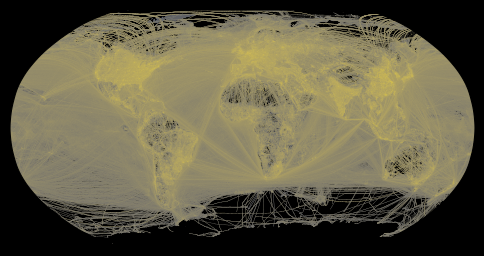

In [6]:
import geopandas as gpd
from shapely.geometry import Point

geometry = [Point(xy) for xy in zip(co2['lon'], co2['lat'])]
gdf = gpd.GeoDataFrame(co2, crs="EPSG:4326", geometry=geometry)

from cartopy import crs as ccrs

fig, ax = plt.subplots(facecolor='black', subplot_kw={'projection': ccrs.Robinson()})
ax.patch.set_facecolor('black')
fig.set_figwidth(6)
ax = gdf.plot(ax=ax, column='emission', transform=ccrs.PlateCarree(), 
              cmap='cividis', norm = colors.LogNorm(), s=0.05, edgecolors='none')
plt.show()

Now in a manner similar to the research figures from EDGAR, I'll apply a custom color boundary for different GHG cutoffs.

Add a colorbar legend: -Create a new axes(cax) on the figure to hold the colorbar.

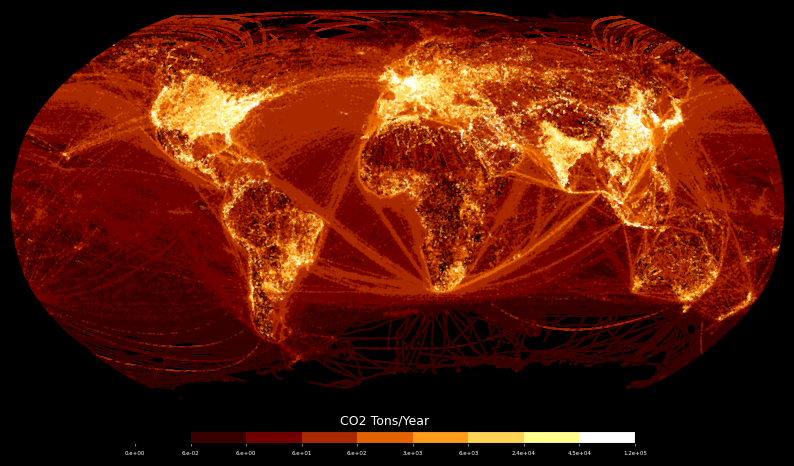

In [8]:
import numpy as np
from matplotlib import cm #colormaps
from matplotlib.colors import ListedColormap

bounds = [0.0, 0.06, 6, 60, 600, 3000, 6000, 24000, 45000, 120000]
our_cmap = plt.get_cmap('afmhot', len(bounds))
newcolors = our_cmap(np.linspace(0, 1, len(bounds)))
newcolors = newcolors[1:]
norm = colors.BoundaryNorm(bounds, our_cmap.N)

fig, ax = plt.subplots(facecolor='black', subplot_kw={'projection': ccrs.Robinson()}, 
                       figsize=(10,6))
ax.patch.set_facecolor('black')

ax = gdf.plot(ax=ax, column='emission', transform=ccrs.PlateCarree(), 
              cmap=our_cmap, norm= norm, s=0.05, alpha=1)

cax = fig.add_axes([0.25, 0.1, 0.5, 0.02]) # format is left start %, bottom start %, width %, height %
cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=our_cmap), orientation='horizontal', 
                    drawedges=False, cax=cax)
cbar.set_label('CO2 Tons/Year', color='white', labelpad=5, fontsize=9)
cbar.ax.xaxis.set_label_position('top')

# Add ticks and labels for the bound cutoffs
tick_labels = [str(np.format_float_scientific(bound, precision=1)) for bound in bounds] #turns each value into a string and adds to a list
cbar.set_ticks(bounds)
cbar.set_ticklabels(tick_labels, color='white', fontsize=4)
cbar.ax.tick_params(axis='x', which='both', direction='out', length=2, color='grey')

plt.show()


In [10]:
fig.savefig('map6.png', dpi=300)